In [2]:
import requests
import os

def download_sam_checkpoint(model_type="vit_h", save_directory="model/"):
    """Downloads the SAM checkpoint file for the specified model type."""

    if model_type not in ["vit_h", "vit_l", "vit_b"]:
        raise ValueError("Invalid model_type. Choose from 'vit_h', 'vit_l', or 'vit_b'.")

    model_filename = f"sam_{model_type}_4b8939.pth"
    model_url = f"https://dl.fbaipublicfiles.com/segment_anything/{model_filename}"

    save_path = os.path.join(save_directory, model_filename)
    os.makedirs(save_directory, exist_ok=True)

    print(f"Downloading {model_filename} to {save_path}...")
    with requests.get(model_url, stream=True) as r:
        r.raise_for_status()
        with open(save_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print("Download complete!")
    return save_path

download_sam_checkpoint()

Download complete!


'model/sam_vit_h_4b8939.pth'

In [8]:
import os
import torch
import rasterio
from samgeo import SamGeo
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert


def process_tif_directory(input_directory, output_directory, checkpoint_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    sam = SamGeo(
        checkpoint=checkpoint_path,
        model_type='vit_h',
        device=device,
        erosion_kernel=(3, 3),
        mask_multiplier=255,
        sam_kwargs=None,
    )

    for filename in os.listdir(input_directory):
        if filename.endswith(".tif"):
            tif_path = os.path.join(input_directory, filename)
            output_mask = os.path.join(output_directory, f"mask_{filename}")
            output_vector = os.path.join(
                output_directory, f"vector_{filename[:-4]}.gpkg"
            )
            output_boundaries = os.path.join(output_directory, f"boundaries_{filename}")

            # Generate mask using the 'generate' method
            sam.generate(tif_path, output_mask)

            # Load the generated mask and original image within the same context
            with rasterio.open(tif_path) as src, rasterio.open(output_mask) as mask_src:
                image_array = src.read()  # Read the image array first
                masks = mask_src.read()

                # Combine and skeletonize mask
                combined_mask = np.any(masks, axis=0).astype(np.uint8) * 255

                # Invert the COMBINED MASK (not the skeleton)
                inverted_mask = np.invert(combined_mask)

                # Find contours in the INVERTED mask (to get farm outlines)
                contours, _ = cv2.findContours(inverted_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

                # Create a blank mask to draw the boundaries on
                mask_with_boundaries = np.zeros_like(inverted_mask)

                # Draw single-pixel white boundaries directly on the mask
                cv2.drawContours(mask_with_boundaries, contours, -1, 255, 3)

                # Get image array for display (same as before)
                image_array = src.read()

                # Convert combined mask to grayscale for OpenCV
                combined_mask_gray = combined_mask.astype(np.uint8)

                # Find contours
                contours, _ = cv2.findContours(combined_mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Convert image_array from rasterio format to OpenCV format
                image_cv2 = np.moveaxis(image_array, 0, -1)

                # Draw green boundaries
                image_with_boundaries = image_cv2.copy()
                for contour in contours:
                    cv2.drawContours(image_with_boundaries, [contour], -1, (0, 255, 0), 2)

                 # Convert the mask to vector (same as before)
                sam.tiff_to_gpkg(output_mask, output_vector, simplify_tolerance=None)

                # Save the mask with boundaries as a GeoTIFF
                with rasterio.open(output_boundaries, 'w', **src.profile) as dst:
                    dst.write(mask_with_boundaries, indexes=1)

                 # Save the image with green boundaries as a GeoTIFF
                with rasterio.open(
                    os.path.join(output_directory, f"boundaries_on_image_{filename}"), 'w', **src.profile
                ) as dst:
                    dst.write(image_with_boundaries.transpose(2, 0, 1))  # Transpose for Rasterio

                # Display the original image, combined mask, and image with boundaries side-by-side
                display_results(image_cv2, mask_with_boundaries, image_with_boundaries)


def display_results(image_array, mask_with_boundaries, image_with_boundaries):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6)) # Adjusted for 3 subplots
    show(np.moveaxis(image_array, -1, 0), ax=ax1, title="Original Image") # Converted back for rasterio
    show(mask_with_boundaries, ax=ax2, cmap='gray', title="Combined Mask")
    show(np.moveaxis(image_with_boundaries, -1, 0), ax=ax3, title="Image with Boundaries") # Converted back for rasterio
    plt.show()

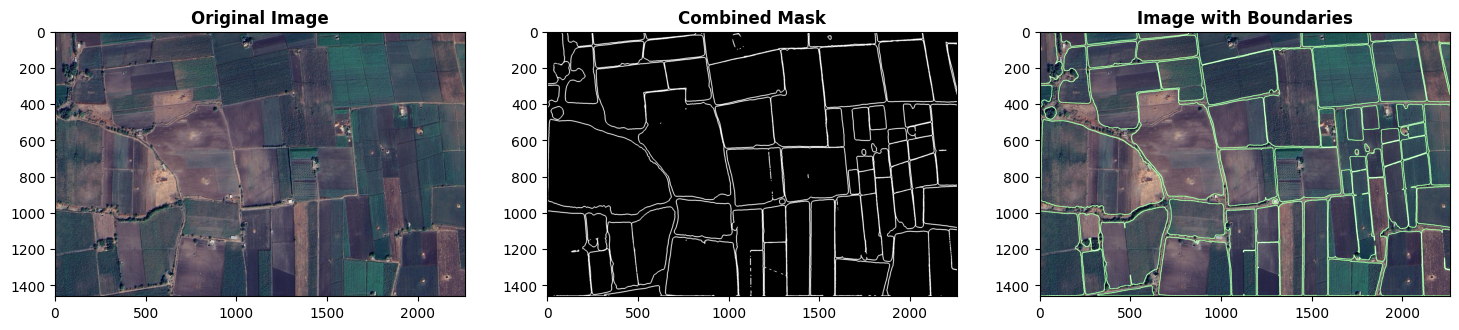

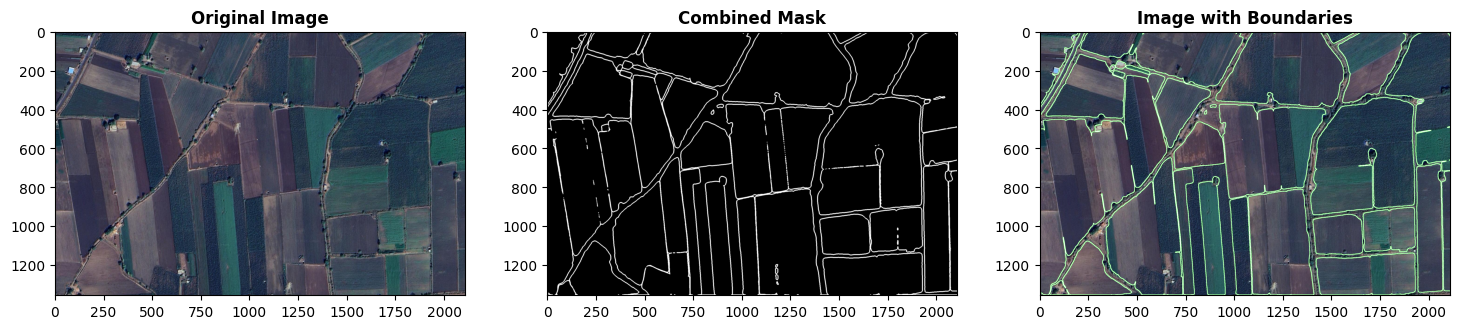

In [9]:
input_directory = "./data"
output_directory = "./output"
checkpoint_path = "./model/"'your download_sam_checkpoint'""
process_tif_directory(input_directory, output_directory, checkpoint_path)

In [10]:
import shutil

shutil.make_archive('/content/output', 'zip', '/content/output')

'/content/output.zip'